# Replay buffer for MNIST classification

In [2]:
import os
import jax
import optax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable, Tuple
from flax.training.train_state import TrainState

In [3]:
from rebayes import sgd
from dynamax.utils import datasets
from rebayes import replay_sgd as rsgd

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%config InlineBackend.figure_format = "retina"

# (Sorted) rotated MNIST

In [135]:
np.random.seed(314)
num_train = 10_000

train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X = jnp.array(X_train)[:num_train]
y = jnp.array(y_train)[:num_train]

ix_sort = jnp.argsort(y)
X = X[ix_sort]
y = y[ix_sort]

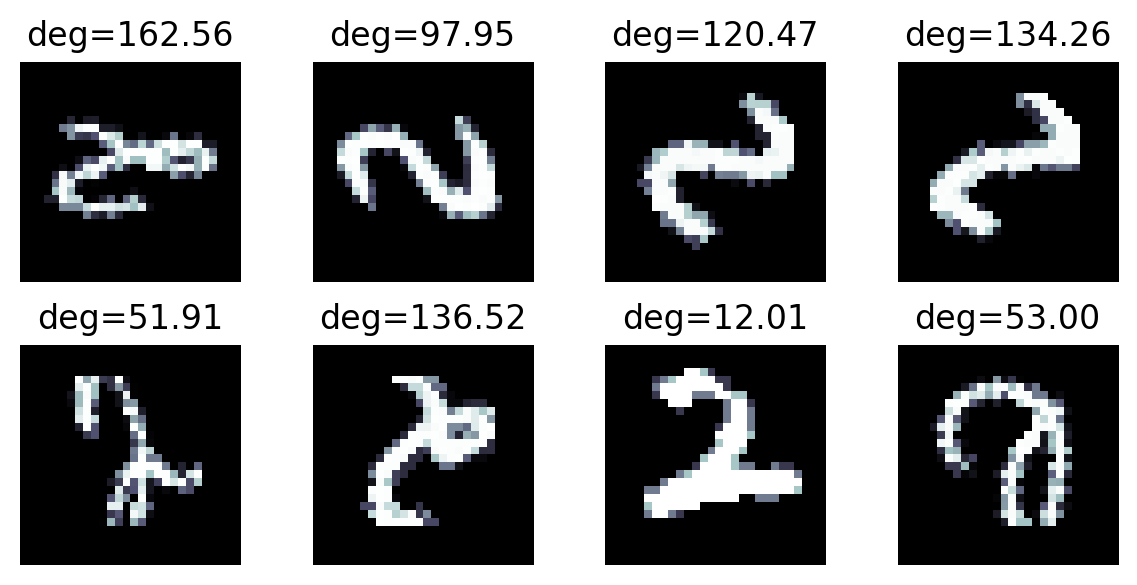

In [136]:
np.random.seed(314)
n_test = 8
ixs_test = np.random.randint(0, len(X_train), size=n_test)

fig, axs = plt.subplots(2, 4, figsize=(6, 3))
axs = axs.ravel()
for ax, ix in zip(axs, ixs_test):
    img = X_train[ix]
    deg = y_train[ix]
    ax.imshow(img.reshape(28, 28), cmap="bone")
    ax.axis("off")
    ax.set_title(f"{deg=:0.2f}")
plt.tight_layout()

# Training

## Setup

In [137]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [138]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

## Vanilla SGD

In [139]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn(params, X, y, applyfn):
    yhat = applyfn(params, X)
    nll = (y - yhat.ravel()) ** 2
    return nll.mean()


@partial(jax.jit, static_argnames=("applyfn",))
def metric(params, X, y, applyfn):
    yhat = applyfn(params, X)
    err = jnp.abs(y - yhat.ravel())
    return err.mean()

In [140]:
%%time
dim_out = 1
num_epochs = 5_000
batch_size = 1000

model = MLP(dim_out, activation=nn.elu)
batch_init = jnp.ones((1, 28 ** 2))
params_init = model.init(key_init, batch_init)

state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-5),
)


state, losses = sgd.train_full(
    key_init, num_epochs, batch_size, state, X, y, lossfn,
    X_test, y_test
)
losses = jax.block_until_ready(losses)

CPU times: user 13.2 s, sys: 400 ms, total: 13.6 s
Wall time: 11.7 s


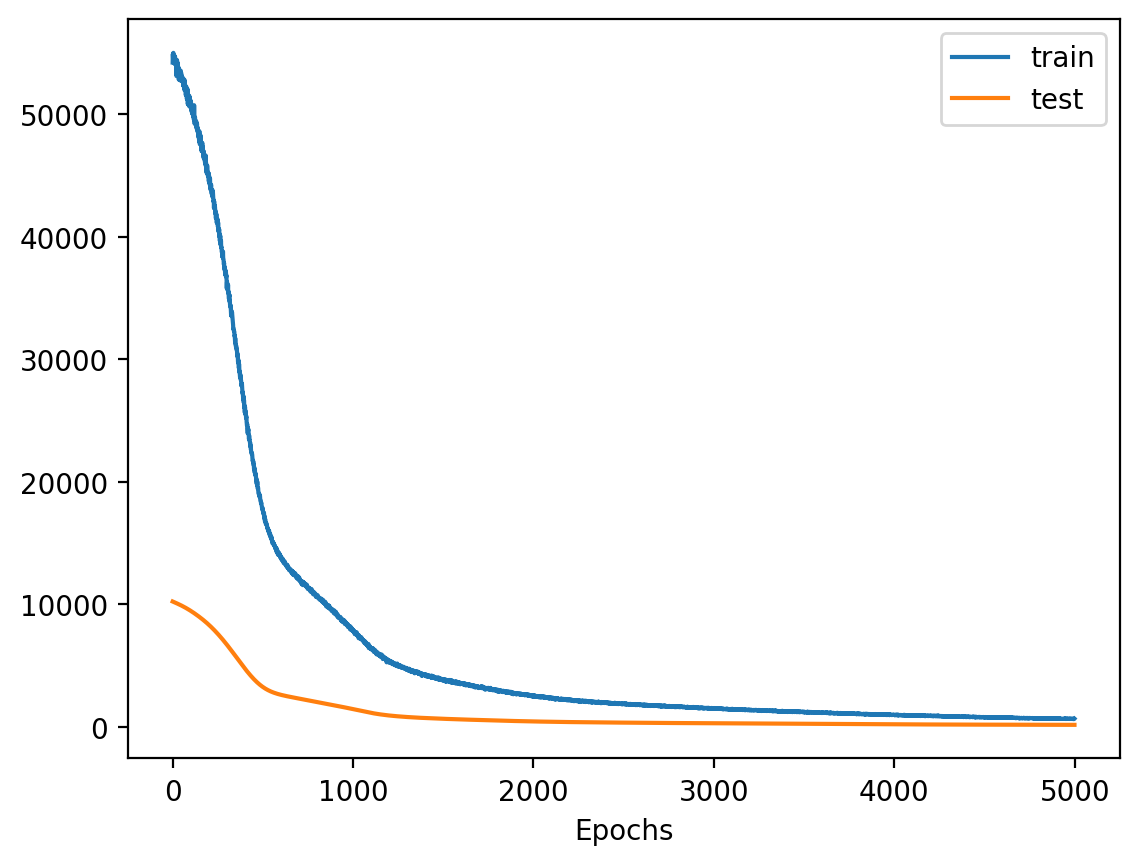

In [141]:
plt.plot(losses["train"], label="train")
plt.plot(losses["test"], label="test")
plt.legend()
plt.xlabel("Epochs");

In [142]:
sgd_loss = metric(state.params, X_test, y_test, state.apply_fn).item()
sgd_loss

9.221481323242188

# Replay buffer FIFO

Consider a buffer with size 4, the minibatches are given by
```
[x0,]
[x0, x1]
[x0, x1, x2]
[x0, x1, x2, x3]
[x1, x2, x3, x4]
[x2, x3, x4, x5]
...
```

In [154]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_fifo(params, counter, X, y, applyfn):
    yhat = applyfn(params, X).ravel()
    loss = (y - yhat) ** 2
    loss = (loss * counter).sum() / counter.sum()
    return loss

In [155]:
model = MLP(dim_out, activation=nn.elu)
batch_init = jnp.ones((dim_out, 28 ** 2))
params_init = model.init(key_init, batch_init)

In [156]:
learning_rate = 1e-5

In [157]:
%%time
dim_features = 28 ** 2

buffer_size = 100
n_inner = 2

state_init = rsgd.FifoTrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim_features,
    dim_output=dim_out,
)


rebayes = rsgd.FSGD(lossfn_fifo, n_inner=n_inner)

test = {"X_test": X_test, "y_test": y_test}
state, losses = rebayes.scan(X, y, bel=state_init, callback=rmae_test, **test)
acc = rmae_test(state, X_test=X_test, y_test=y_test)["test"]
acc = jax.block_until_ready(acc)

  0%|          | 0/5958 [00:00<?, ?it/s]

CPU times: user 4.39 s, sys: 129 ms, total: 4.52 s
Wall time: 3.29 s


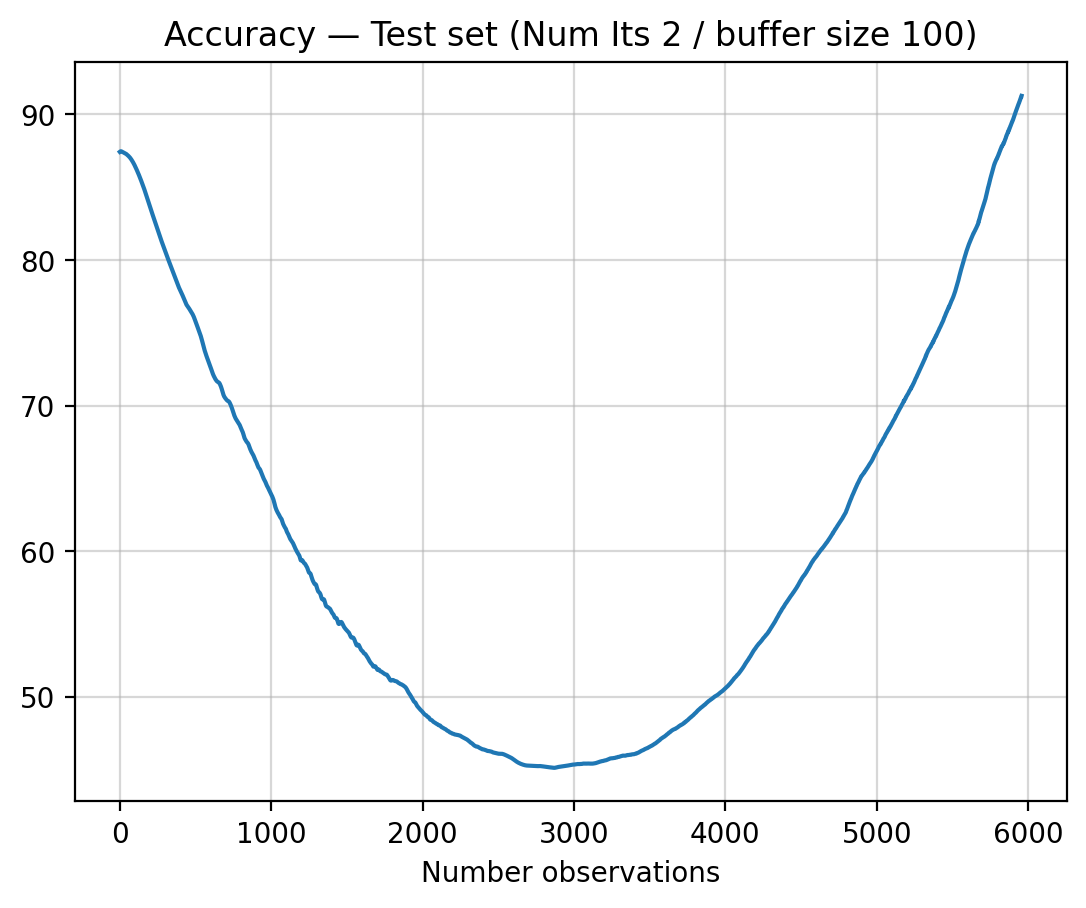

In [158]:
plt.plot(losses["test"])
plt.grid(alpha=0.5)
plt.xlabel("Number observations")
plt.title(f"Accuracy — Test set (Num Its {n_inner} / buffer size {buffer_size})");

In [159]:
%%time
n_inner = 1
buffer_size = 100

@partial(jax.pmap, in_axes=0)
@partial(jax.vmap, in_axes=1)
def init_and_train(key):
    params_init = model.init(key, batch_init)

    rebayes = rsgd.FSGD(lossfn_fifo, n_inner=n_inner)
    
    params_init = model.init(key, batch_init)
    state_init = rsgd.FifoTrainState.create(
        apply_fn=model.apply,
        params=params_init,
        tx=optax.adam(learning_rate),
        buffer_size=buffer_size,
        dim_features=dim_features,
        dim_output=dim_out,
    )
    
    
    state, losses = rebayes.scan(X, y, bel=state_init, callback=rmae_test, pb=False, **test)
    return state, losses
    

n_samples = 8 * 5
keys = jax.random.split(key, n_samples).reshape(8, 2, -1)
states, losses = init_and_train(keys)
losses = jax.block_until_ready(losses)

CPU times: user 11.6 s, sys: 478 ms, total: 12.1 s
Wall time: 9.23 s


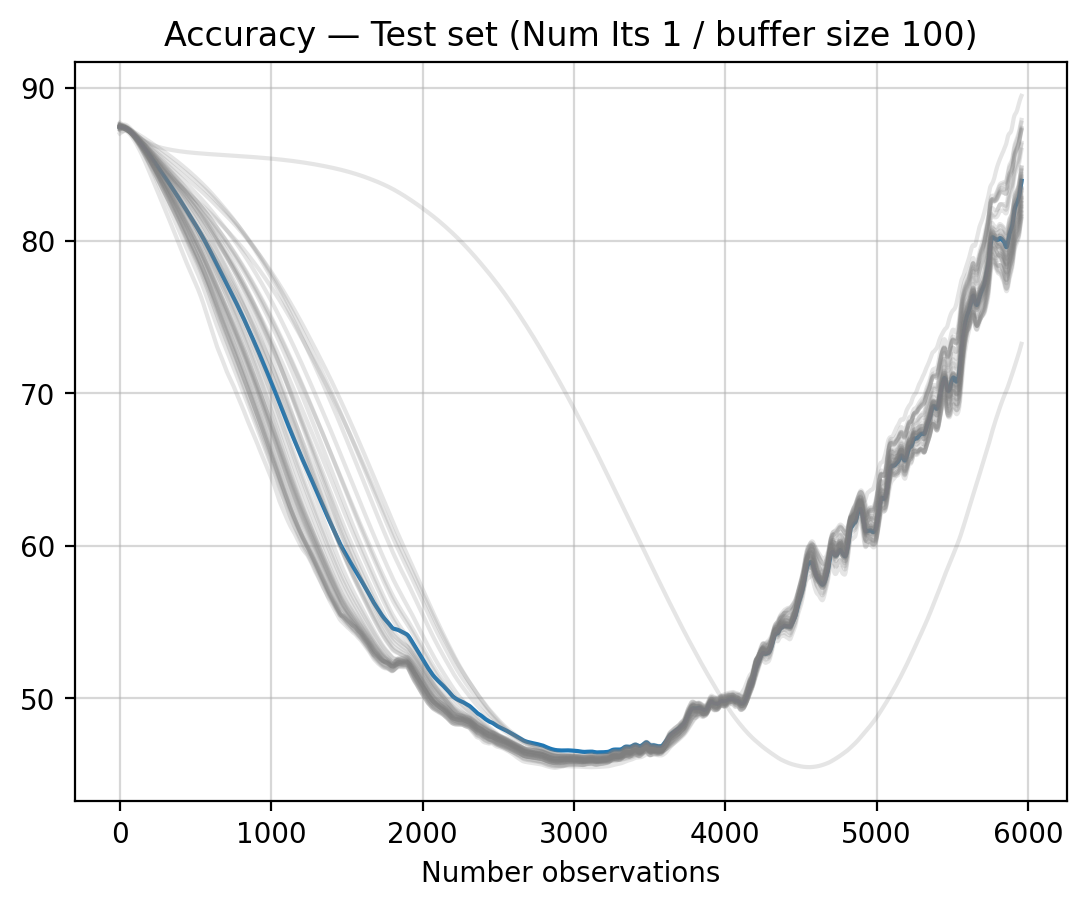

In [160]:
xrange = jnp.ones_like(y).cumsum()
losses_test = losses["test"].reshape(n_samples, -1)
mean_loss = losses_test.mean(axis=0)
std_loss = losses_test.std(axis=0)
plt.plot(xrange, mean_loss)
# plt.fill_between(xrange, mean_loss - 2 * std_loss, mean_loss + 2 * std_loss, alpha=0.3)

for ltest in losses_test:
    plt.plot(ltest, c="tab:gray", alpha=0.2)

plt.grid(alpha=0.5)
plt.xlabel("Number observations")
plt.title(f"Accuracy — Test set (Num Its {n_inner} / buffer size {buffer_size})");

### Multiple buffer sizes

In [163]:
%%time
buffer_size_list = [1, 5, 10, 20, 50, 100, 200, 300]
n_buffers = len(buffer_size_list)

n_inner = 1
test_losses = {}


state_init = rsgd.FifoTrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim_features,
    dim_output=dim_out,
)


for buffer_size in (pbar := tqdm(buffer_size_list)):
    
    state_init_test = state_init.replace(buffer_size=buffer_size)
    
    rebayes = rsgd.FSGD(lossfn_fifo, n_inner=n_inner)
    state, losses = rebayes.scan(X, y, bel=state_init_test, callback=rmae_test, pb=False, **test)
    test_losses[buffer_size] = losses["test"]
    acc = losses["test"][-1]
    pbar.set_description(f"acc-{buffer_size:03}={acc:0.4f}")

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 27.6 s, sys: 543 ms, total: 28.2 s
Wall time: 21 s


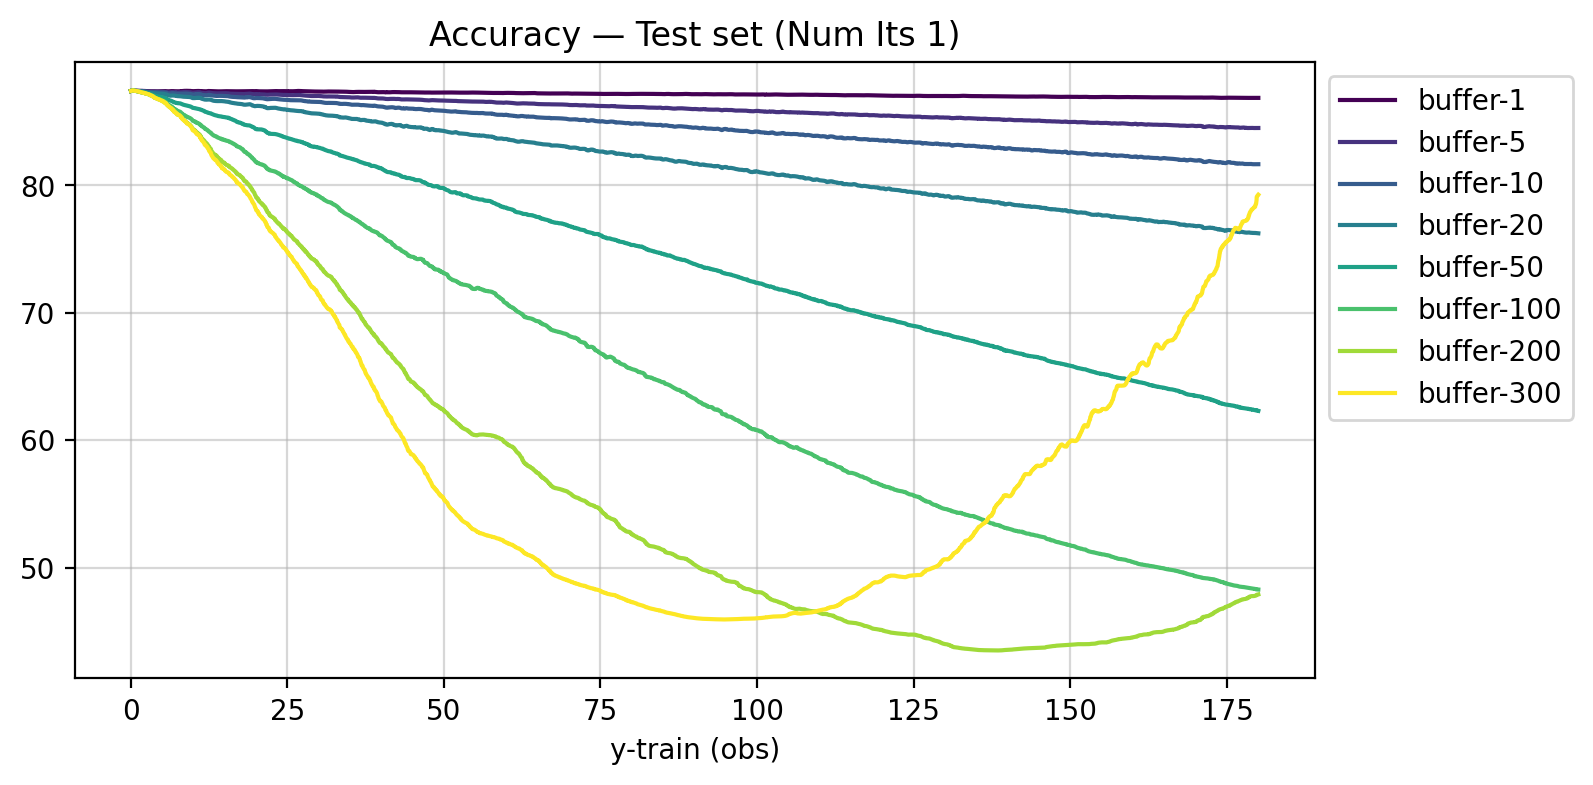

In [164]:
fig, ax = plt.subplots(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, n_buffers))

for c, buffer_size in zip(colors, buffer_size_list):
    loss_test = test_losses[buffer_size]
    plt.plot(y, loss_test, c=c, label=f"buffer-{buffer_size}")
    
plt.xlabel("y-train (obs)")
plt.title(f"Accuracy — Test set (Num Its {n_inner})")
# plt.axhline(y=sgd_loss, c="tab:gray", linestyle="--", label="SGD minibatch")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.5)